# Price prediction code


In [15]:
# IMPORTING IMPORTANT LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from numpy import concatenate as conc
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, precision_recall_fscore_support
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Nadam
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Bidirectional
from keras.utils import plot_model
from keras import backend as K
import os
import time
from datetime import timedelta
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


In [9]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log((y_pred - y_true), axis=-1))))
    
def percentage_change(inp):
    arr =  ((np.diff(inp) / inp[:-1]))
    return arr

def binary(inp):
    l = []
    for i in range(len(inp)):
        if i == 0:
            continue
        else:
            if (inp[i] - inp[i-1]) > 0:
                l.append(1)
            else:
                l.append(0)
    return np.array(l)

def strategy_profit(yhat, yt):
    signal = np.array([1 if p == 1 else -1 for p in binary(yhat)]) # Creates a trading signal to buy if price rises, sell if price drops
    signal = np.hstack((0,signal))
    
    df = pd.DataFrame() # Create dataframe for easier computation
    
    returns = yt.reshape((yt.shape[0], )) # create returns series from original data 
    returns[0] = 0
    
    df["return_strat"] = (returns * signal) # daily returns strategy
    np_return_strat = df["return_strat"].values # numpy array of daily returns
    
    df["cumulative_return_strat"] =((1+df["return_strat"]).cumprod())  # cumulative return of strategy when reinvesting entire portfolio value w/o transaction cost or slippage
    df["return"] = returns 
    df["cumulative_return"] = ((1+df['return']).cumprod()) # Returns of the buy and hold strategy (buy at t=0 and hold untill t=end)
    df["signal"] = signal 
    return float(df.iloc[-1:]["cumulative_return_strat"] - df.iloc[-1:]["cumulative_return"]), (math.sqrt(365) * np.mean(np_return_strat) / np.std(np_return_strat))

In [11]:
# deleting unwanted columns
del dataset["eth_supply"]
del dataset["eth_ethersupply"]
del dataset["eth_marketcap"]
del dataset["Unnamed: 0"]
del dataset["UnixTimeStamp"]
del dataset["eth_ens_register"]

In [14]:
# Make price column the last one for easier use later on
cols = list(dataset)
cols[0], cols[11] = cols[11], cols[0]
dataset = dataset.loc[:,cols]
dataset = dataset[::-1]

In [15]:
# Accounting for blocktime being halved at index 809
dataset["eth_blocktime"].loc[809:] = dataset[809:]["eth_blocktime"] * 2
dataset["eth_uncles"].loc[809:] = dataset[809:]["eth_uncles"] / 2
dataset["eth_blocks"].loc[809:] = dataset[809:]["eth_blocks"] / 2
dataset["eth_difficulty"].loc[809:] = dataset[809:]["eth_difficulty"] * 2
dataset["eth_gasprice"][497] = dataset["eth_gasprice"][497] / 41

In [16]:
# Drop first 13 because of no price values
dataset = dataset[13:]

In [17]:
# Convert to numpy array and normalize data.
dataset = dataset.values
dataset = dataset.astype("float32")
dataset_y = percentage_change(dataset[:, -1])

C:\Users\ikdem\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [18]:
scaler_z = StandardScaler()
dataset_X = scaler_z.fit_transform(dataset[:, :-1])
dataset_X = dataset_X[0:-1:]

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [10]:
## Train/test split
split = int(len(dataset)*0.9)

train_X = dataset_X[:split, :]
test_X = dataset_X[split:, :]

train_y = dataset_y[:split]
test_y = dataset_y[split:]

yt = test_y # for analysis later on

# Reshape for LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(828, 1, 11)
(828,)
(92, 1, 11)
(92,)


In [11]:
def fit_model1_oleb(optimizer, loss_function, epochs = 10, batch_size = 1):
    
    model = Sequential()

    model.add((LSTM(64, input_shape=(1, 11), return_sequences = True))) 
    model.add(Activation("relu"))

    model.add((LSTM(128, input_shape=(1, 11), return_sequences = True)))
    model.add(Activation("relu"))

    model.add((LSTM(128, input_shape=(1, 11))))
    model.add(Activation("relu"))

    model.add(Dense(64))
    model.add(Activation("relu"))

    model.add(Dense(32))
    model.add(Dense(1))

    model.add(Activation('linear'))

    # Compile and Run
    model.compile(loss= loss_function , optimizer = optimizer) # Try SGD, adam, adagrad and compare!!!
    model.fit(train_X, train_y, epochs = epochs, batch_size = batch_size, verbose=0)
    yhat = model.predict(test_X)
    
    return yhat
    

In [12]:
def fit_model1_neurons(n1, n2, n3, n4):
    model = Sequential()

    model.add((LSTM(n1, input_shape=(1, 11), return_sequences = True))) 
    model.add(Activation("relu"))

    model.add((LSTM(n2, input_shape=(1, 11), return_sequences = True)))
    model.add(Activation("relu"))

    model.add((LSTM(n2, input_shape=(1, 11))))
    model.add(Activation("relu"))

    model.add(Dense(n3))
    model.add(Activation("relu"))

    model.add(Dense(n4))
    model.add(Dense(1))

    model.add(Activation('linear'))

    # Compile and Run
    model.compile(loss= "mean_squared_error" , optimizer = RMSprop(lr=0.0005)) # Try SGD, adam, adagrad and compare!!!
    model.fit(train_X, train_y, epochs = 1000, batch_size = 64, verbose=0)
    yhat = model.predict(test_X)
    
    return yhat

In [13]:
def fit_model2_n(n1, n2):
    model = Sequential()

    model.add((LSTM(n1, input_shape=(1, 11), return_sequences= True)))
    
    model.add((LSTM(n2, input_shape=(1, 11))))

    model.add(Dense(n3))
    model.add(Dense(1))

    model.add(Activation('linear'))

    # Compile and Run
    model.compile(loss= "mean_squared_error" , optimizer = RMSprop(lr=0.0005)) # Try SGD, adam, adagrad and compare!!!
    model.fit(train_X, train_y, epochs = 2500, batch_size = 64, verbose=0)
    yhat = model.predict(test_X)
    
    return yhat

In [14]:
# plt.figure(figsize=(50,50))

# count = 1

# d = {}

# for n1 in [4, 8, 16, 32, 64, 128, 256]:
#     for n2 in [4, 8, 16, 32, 64, 128, 256]:
#         print("Starting to train model #" + str(count))
#         start_time = time.time()
        
#         yhat = fit_model2_n(n1, n2)

#         plt.subplot(15, 4, count)
#         plt.plot(yhat, "g", label = "predicted")
#         plt.plot(yt, "r", label = "real")
#         plt.title("n1: {} n2: {}".format(str(n1), str(n2))) 

#         rmse_normalized = math.sqrt(mean_squared_error(yhat, yt))
#         mae_normalized = mean_absolute_error(yhat, yt)
#         excess_r, sharpe = strategy_profit(yhat, yt)

#         d["n1: {} n2: {}".format(str(n1), str(n2))] = \
#         ["rmse: " + str(rmse_normalized), 
#             "mae: " + str(mae_normalized),
#                 precision_recall_fscore_support(binary(yhat), binary(yt), average = 'weighted'),
#                     "strategy profit in %: " + str(excess_r),
#                         "Sharpe ratio: " + str(sharpe),
#                             yhat]

#         print("Finished training model #{} with training time of: {} (h:mm:ss)".format(str(count), timedelta(seconds=round(time.time() - start_time))))
#         count += 1
#         print("------------------")

# plt.legend()
# plt.savefig("test.png")
# plt.show()

In [15]:
def fit_model2_oleb(o, l, e, b):
    model = Sequential()

    model.add((LSTM(256, input_shape=(1, 11)))) 

    model.add(Dense(1))

    model.add(Activation('linear'))

    # Compile and Run
    model.compile(loss = l, optimizer = o) # Try SGD, adam, adagrad and compare!!!
    model.fit(train_X, train_y, epochs = e, batch_size = b, verbose=0)
    yhat = model.predict(test_X)
    
    return yhat

Starting to train model #1
Finished training model #1 with training time of: 0:01:17
------------------
Starting to train model #2
Finished training model #2 with training time of: 0:02:15
------------------
Starting to train model #3
Finished training model #3 with training time of: 0:03:37
------------------
Starting to train model #4
Finished training model #4 with training time of: 0:07:35
------------------
Starting to train model #5
Finished training model #5 with training time of: 0:08:19
------------------
Starting to train model #6
Finished training model #6 with training time of: 0:14:27
------------------
Starting to train model #7
Finished training model #7 with training time of: 0:12:42
------------------
Starting to train model #8
Finished training model #8 with training time of: 0:19:58
------------------
Starting to train model #9
Finished training model #9 with training time of: 0:12:54
------------------
Starting to train model #10
Finished training model #10 with tra

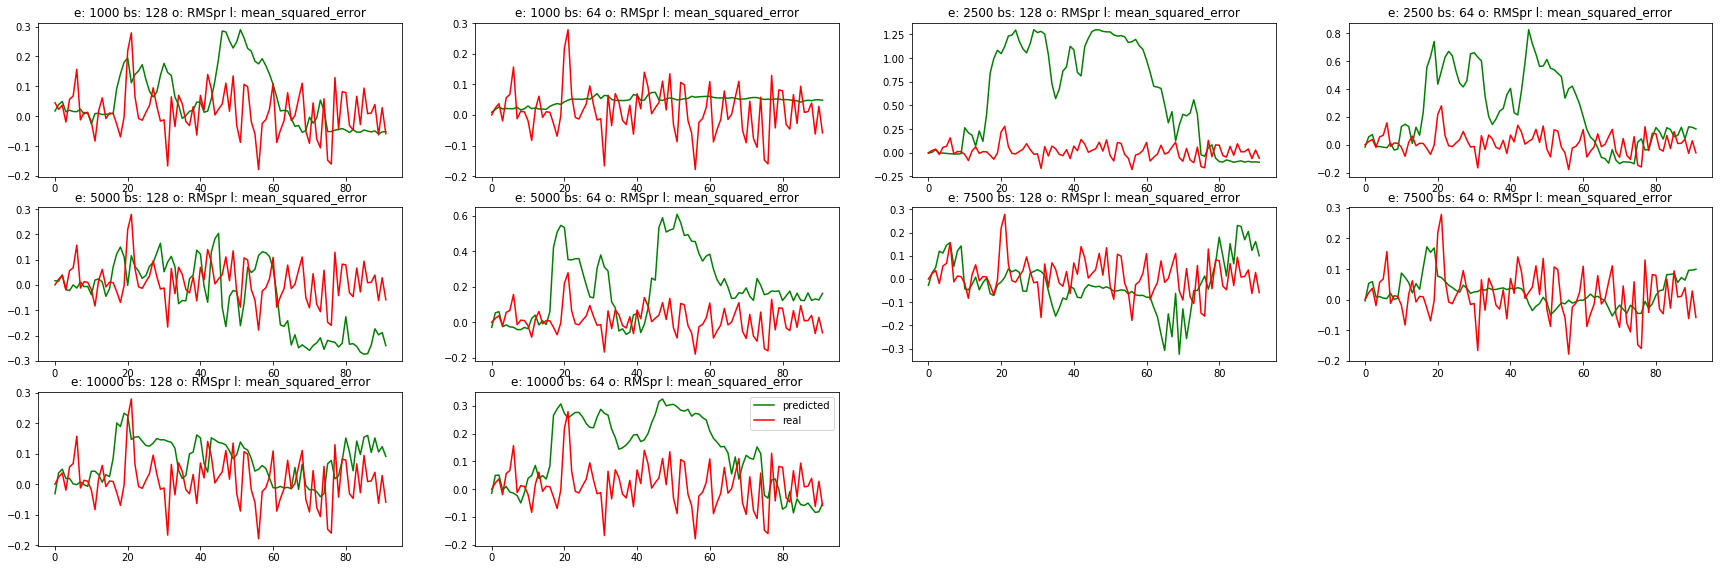

In [16]:
# Gridsearch all but neurons
n_epochs = [1000, 2500, 5000, 7500, 10000] 
n_batch_size = [128, 64]
n_optimizers = [RMSprop(lr = 0.0005)]
n_loss = ["mean_squared_error"]

plt.figure(figsize=(30,30))

count = 1

d = {}

for e in n_epochs:
    for b in n_batch_size:
        for o in n_optimizers:
            for l in n_loss:
                print("Starting to train model #" + str(count))
                start_time = time.time()
                
                yhat = fit_model1_oleb(o, l, e, b)
                
                plt.subplot(9, 4, count)
                plt.plot(yhat, "g", label = "predicted")
                plt.plot(yt, "r", label = "real")
                plt.title("e: {} bs: {} o: {} l: {}".format(str(e), str(b), str(o)[18:23], l)) 
                
                rmse_normalized = math.sqrt(mean_squared_error(yhat, yt))
                mae_normalized = mean_absolute_error(yhat, yt)
                excess_r, sharpe = strategy_profit(yhat, yt)
                
                d["e: {} bs: {} o: {} l: {}".format(str(e), str(b), str(o)[18:23], l)] = \
                ["rmse: " + str(rmse_normalized), 
                    "mae: " + str(mae_normalized),
                        precision_recall_fscore_support(binary(yhat), binary(yt), average = 'weighted'),
                            "strategy profit in %: " + str(excess_r),
                                "Sharpe ratio: " + str(sharpe),
                                    yhat]
                
                print("Finished training model #{} with training time of: {}".format(str(count), timedelta(seconds=round(time.time() - start_time))))
                count += 1
                print("------------------")

plt.legend()
plt.savefig("test.png")
plt.show()

In [17]:
# # Gridsearch neurons
# n1l = [256]
# n2l = [16, 32, 64, 128, 256]
# n3l = [8, 16, 32, 64]
# n4l = [2, 4, 8]

# plt.figure(figsize=(60,60))

# count = 1

# d = {}

# # FIT NEURONS IN NETWORK
# for n1 in n1l:
#     for n2 in n2l:
#         for n3 in n3l:
#             for n4 in n4l:
#                 print("Starting to train model #" + str(count))
#                 start_time = time.time()
#                 yhat = fit_model1_neurons(n1, n2, n3, n4)
                
#                 plt.subplot(15, 4, count)
#                 plt.plot(yhat, "g", label = "predicted")
#                 plt.plot(yt, "r", label = "real")
#                 plt.title("n1: {} n2: {} n3: {} n4: {}".format(str(n1), str(n2), str(n3), str(n4))) 
                
#                 rmse_normalized = math.sqrt(mean_squared_error(yhat, yt))
#                 mae_normalized = mean_absolute_error(yhat, yt)
#                 excess_r, sharpe = strategy_profit(yhat, yt)
                
#                 d["n1: {} n2: {} n3: {} n4: {}".format(str(n1), str(n2), str(n3), str(n4))] = \
#                 ["rmse: " + str(rmse_normalized), 
#                     "mae: " + str(mae_normalized),
#                         precision_recall_fscore_support(binary(yhat), binary(yt), average = 'weighted'),
#                             "strategy profit in %: " + str(excess_r),
#                                 "Sharpe ratio: " + str(sharpe),
#                                     yhat]
                  
#                 elapsed_time_secs = time.time() - start_time
#                 print("Finished training model #{} with training time of: {}".format(str(count), timedelta(seconds=round(elapsed_time_secs))))
#                 count += 1
                
#                 print("------------------")

# plt.legend()
# plt.savefig("test.png")
# plt.show()

In [21]:
for key, value in d.items():
    print(key, "\n", value[0:5])
    print("\n")

e: 7500 bs: 64 o: RMSpr l: mean_squared_error 
 ['rmse: 0.08724875247747967', 'mae: 0.06770073', (0.5198810850984764, 0.5164835164835165, 0.5171849427168576, None), 'strategy profit in %: -160.25251664779267', 'Sharpe ratio: -0.5547728893544649']


e: 7500 bs: 128 o: RMSpr l: mean_squared_error 
 ['rmse: 0.12874372669556616', 'mae: 0.101438224', (0.5384615384615384, 0.5384615384615384, 0.5384615384615384, None), 'strategy profit in %: 8.056219041780139', 'Sharpe ratio: 2.969584451914447']


e: 2500 bs: 128 o: RMSpr l: mean_squared_error 
 ['rmse: 0.7979314196810533', 'mae: 0.63457406', (0.3804215108562935, 0.37362637362637363, 0.3759054771789763, None), 'strategy profit in %: -193.2110267557692', 'Sharpe ratio: -2.708580214499257']


e: 10000 bs: 128 o: RMSpr l: mean_squared_error 
 ['rmse: 0.11301103789720518', 'mae: 0.09138403', (0.49017890322238145, 0.4835164835164835, 0.4853957443405594, None), 'strategy profit in %: -192.05784855993576', 'Sharpe ratio: -2.5539181583637864']


e: 1

In [20]:
plot_model(model, to_file='model.png')

NameError: name 'model' is not defined

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yt = test_y
yhat = model.predict(test_X)

In [ ]:
yhat = d["e:500 bs:128 o:RMSprl:mean_squared_error"][4]

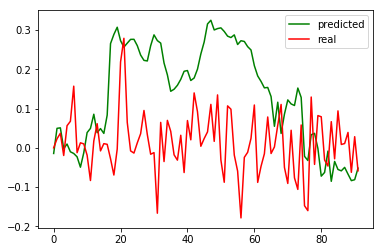

In [22]:
plt.plot(yhat, "g", label = "predicted")
plt.plot(yt, "r", label = "real")
plt.legend()
plt.show()

In [23]:
#rmse = math.sqrt(mean_squared_error(inv_yhat, inv_yt))
#mae = mean_absolute_error(inv_yhat, inv_yt)
rmse_normalized = math.sqrt(mean_squared_error(yhat, yt))
mae_normalized = mean_absolute_error(yhat, yt)
print(rmse_normalized, mae_normalized)
# print(rmse, mae, "original errors")

0.18812549091984768 0.15467377


In [24]:
print(classification_report(binary(yhat), binary(yt)))

             precision    recall  f1-score   support

          0       0.41      0.41      0.41        46
          1       0.40      0.40      0.40        45

avg / total       0.41      0.41      0.41        91



In [25]:
returns = yt.reshape((yt.shape[0], ))

In [26]:
signal = np.array([1 if p == 1 else -1 for p in binary(yhat)])
signal = np.hstack((0,signal))

In [27]:
df = pd.DataFrame()

In [28]:
df["return_strat"] = (returns * signal) 
df["cumulative_return_strat"] = ((1 + df['return_strat']).cumprod() - 1) * 100
df["return"] = returns 
df["cumulative_return"] = (df["return"].cumsum())*100
df["signal"] = signal

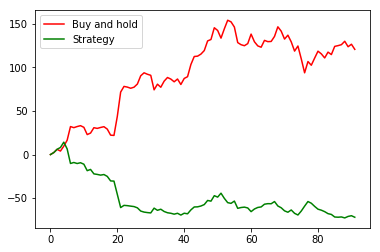

In [29]:
plt.plot(df["cumulative_return"], "r", label = "Buy and hold")
plt.plot(df["cumulative_return_strat"], "g", label = "Strategy")
plt.plot()
plt.legend()
plt.show()